# 20211012-simpoints
Evaluate IPCs, accuracy, and coverage over simpoints for the base prefetchers.

In [1]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import attrdict
import matplotlib.pyplot as plt

---
# User parameters.

You can look at the simpoint-weights or the data to get the trace_id for the trace you want.

In [2]:
traces = [
    '473.astar',
    '471.omnetpp',
    '429.mcf'
]

simpoints_dir = 'data/simpoint-weights/'
results_dir = 'data/base-prefetch1-fixedcache-500m/'
max_instruction_num = 250 # in millions
min_instruction_interval = 3.9 # in millions (this does not affect IPC results much)

---
# Load simpoint weights and results.

In [3]:
# Some spec06 traces (that we don't have) don't have an associated trace ID,
# so for now I put 000 as their ID in simpoint-weights.
#
# TODO make a gap simpoint-weights will each trace's simpoints evenly weighted.
def load_simpoint_weights(simpoints_dir, trace):
    """Load simpoint weights for a given trace."""
    simpoints = pd.DataFrame(columns=['trace', 'weight'])
    for f in glob.glob(os.path.join(simpoints_dir, '*.csv')):
        df = pd.read_csv(f)
        simpoints = pd.concat((simpoints, df))
    tr_points = simpoints[simpoints.trace.str.contains(trace)]
    weights = np.array(tr_points.weight.array)
    return weights

In [4]:
simpoint_weights = {}
for tr in traces:
    simpoint_weights[tr] = load_simpoint_weights(simpoints_dir, tr)

In [5]:
print('Simpoint weights:')
for tr in traces:
    print(f'{tr:12} : {simpoint_weights[tr]} largest = s{simpoint_weights[tr].argmax()}') # Why don't mcf weights add to 100?

Simpoint weights:
473.astar    : [0.452174 0.162319 0.22029 ] largest = s0
471.omnetpp  : [0.0309654 0.954463  0.010929 ] largest = s1
429.mcf      : [0.154639 0.175258 0.329897] largest = s2


In [57]:
def parse_champsim_result_file(f, max_instruction_num=None, min_instruction_interval=0):
    data = {
        'instructions': [],
        'cycles': [],
        'heartbeat_ipcs': [],
        'cumulative_ipcs': [],
        'cumulative_sim_times': [],
    }
    
    last_instruction = 0
    warmups_completed = 0 # 0 = none, 1 = CPU, 2 = CPU + prefetch
    for line in f:
        line_tokens = line.split(' ')
        
        # Only append data after the prefetch warmup completes.
        # DEBUG - Hardcoded stop condition (for now. It should stop
        # automatically, but for some reason it doesn't).
        if 'Warmup complete' in line:
            warmups_completed += 1
        
        if 'Heartbeat' in line:
            #print(line)
            instructions = int(line_tokens[line_tokens.index('instructions:') + 1])
            cycles = int(line_tokens[line_tokens.index('cycles:') + 1])
            heartbeat_ipc = float(line_tokens[line_tokens.index('heartbeat') + 2])
            cumulative_ipc = float(line_tokens[line_tokens.index('cumulative') + 2])
            cumulative_sim_time = int(line_tokens[line_tokens.index('time:') + 1]) * 3600 \
                              + int(line_tokens[line_tokens.index('time:') + 3]) * 60 \
                              + int(line_tokens[line_tokens.index('time:') + 5]) \

            # DEBUG - Temporary fix until we can figure out why
            # ChampSim runs too long.
            if max_instruction_num and instructions >= max_instruction_num: 
                warmups_completed = 0
            
            if warmups_completed >= 2 and instructions - last_instruction > min_instruction_interval:
                data['instructions'].append(instructions)
                data['cycles'].append(cycles)
                data['heartbeat_ipcs'].append(heartbeat_ipc)
                data['cumulative_ipcs'].append(cumulative_ipc)
                data['cumulative_sim_times'].append(cumulative_sim_time)
                last_instruction = instructions
        
        if 'LLC PREFETCH' in line and 'REQUESTED' in line:
            data['useful_prefetches'] = int(line.split()[-3])
            data['useless_prefetches'] = int(line.split()[-1])
        if 'LLC LOAD' in line:
            data['llc_load_hits'] = int(line.split()[-3])
        if 'LLC RFO' in line:
            data['llc_rfo_hits'] = int(line.split()[-3])
            
    safediv = lambda x, y : x / y if y != 0 else 0
    data['accuracy'] = safediv(data['useful_prefetches'], (data['useful_prefetches'] + data['useless_prefetches']))
    # Coverage must be calculated separately, since it depends on the baseline prefetcher.
    
    return attrdict.AttrDict(data)

def load_champsim_base_results(base, tracename, **kwargs):
    base_path = base + f'*{tracename}*.txt'
    data = {}
    print('Loading results from:', base_path)
    variation_paths = sorted(glob.glob(base_path))
    for path in variation_paths:
        if '-bo' in os.path.basename(path):
            variation_name = 'BO'
        elif '-sisb_bo' in os.path.basename(path):
            variation_name = 'ISB+BO'
        elif '-sisb-' in os.path.basename(path):
            variation_name = 'ISB'
        elif '-no' in os.path.basename(path):
            variation_name = 'NoPrefetcher'
        else:
            continue
        with open(path, 'r') as f:
            data[variation_name] = parse_champsim_result_file(
                f, **kwargs
            )
    print('    Found variations:', *data.keys())
    return data

In [58]:
results = {}
for tr in traces:
    print(tr)
    base_data = []
    for i in range(len(simpoint_weights[tr])):
        base_data.append(load_champsim_base_results(
            results_dir, f'{tr}-s{i}', 
            max_instruction_num=max_instruction_num * 1000000,
            min_instruction_interval=int(min_instruction_interval * 1000000)
        ))
    results[tr] = base_data

473.astar
Loading results from: data/base-prefetch1-fixedcache-500m/*473.astar-s0*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*473.astar-s1*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*473.astar-s2*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
471.omnetpp
Loading results from: data/base-prefetch1-fixedcache-500m/*471.omnetpp-s0*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*471.omnetpp-s1*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*471.omnetpp-s2*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
429.mcf
Loading results from: data/base-prefetch1-fixedcache-500m/*429.mcf-s0*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*429.mcf-s1*.txt
    Found

---
# IPC measurements
IPC = Instructions per cycle
- WGM: Take the weighted geometric mean of IPCs for the given trace, using the simpoint weights.
    - WGM Cumulative IPCs
    - WGM IPC speedup, vs no prefetcher
- Largest simpoint: Only consider IPC measurements from the longest (largest share) simpoint.
    - LS Cumulative IPCs
    - LS IPC speedup, vs no prefetcher
- **TODO**: Include Paper values

In [59]:
def get_simpoint_ipcs(results):
    """Parse the results dictionary to get an array
    of simpoint IPCs for each prefetcher. For prefetcher 
    p, simpoint_ipcs[p][i] is the cumulative IPC of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_ipcs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_ipcs[pf][spidx] = sp[pf].cumulative_ipcs[-1] 
    return simpoint_ipcs

def get_wgm_ipcs(results, simpoint_weights):
    """Calculate the weighted geometric mean cumulative IPC 
    of each prefetcher over the simpoints.
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    wgm_ipcs = {}
    for pf in simpoint_ipcs:
        wgm_ipcs[pf] = stats.mstats.gmean(simpoint_ipcs[pf], weights=simpoint_weights)
    return wgm_ipcs

def get_wgm_ipc_speedups(results, simpoint_weights, baseline_prefetcher='NoPrefetcher'):
    """Calcualte the weighted geometric mean cumulative IPC
    of each prefetcher, then get the relative IPC against the weighted 
    geometric mean of the baseline prefetcher, to get speedup.
    
    TODO - is the above method correct?
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    wgm_ipc_speedups = {}
    
    for pf in simpoint_ipcs:
        rel_ipcs = 1 + ((simpoint_ipcs[pf] - simpoint_ipcs[baseline_prefetcher])/simpoint_ipcs[baseline_prefetcher])
        wgm_rel_ipc = stats.mstats.gmean(rel_ipcs, weights=simpoint_weights)
        wgm_ipc_speedups[pf] = wgm_rel_ipc - 1.
    return wgm_ipc_speedups

def get_ls_ipcs(results, simpoint_weights):
    """Calculate the largest simpoint cumulative IPC
    of each prefetcher.
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    longest = np.argmax(simpoint_weights)
    ls_ipcs = {}
    for pf in simpoint_ipcs:
        ls_ipcs[pf] = simpoint_ipcs[pf][longest]
    return ls_ipcs
    
def get_ls_ipc_speedups(results, simpoint_weights, baseline_prefetcher='NoPrefetcher'):
    """Calculate the largest simpoint cumulative IPC speedup
    of each prefetcher.
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    longest = np.argmax(simpoint_weights)
    #print('Longest:', longest, simpoint_weights)
    ls_ipc_speedups = {}
    
    for pf in simpoint_ipcs:
        ls_rel_ipc = 1 + ((simpoint_ipcs[pf][longest] - simpoint_ipcs[baseline_prefetcher][longest]) / simpoint_ipcs[baseline_prefetcher][longest])
        ls_ipc_speedups[pf] = ls_rel_ipc - 1
    return ls_ipc_speedups

In [60]:
wgm_ipcs, wgm_ipc_speedups = {}, {}
ls_ipcs, ls_ipc_speedups = {}, {}

for tr in traces:
    wgm_ipcs[tr] = get_wgm_ipcs(results[tr], simpoint_weights[tr])
    wgm_ipc_speedups[tr] = get_wgm_ipc_speedups(results[tr], simpoint_weights[tr])
    ls_ipcs[tr] = get_ls_ipcs(results[tr], simpoint_weights[tr])
    ls_ipc_speedups[tr] = get_ls_ipc_speedups(results[tr], simpoint_weights[tr])

#### Cumulative IPCs

In [125]:
def plot_ipcs(ipcs, subtitle=None):
    """Plot (weighted geometric) mean IPCs for a
    list of prefetchers.
    """
    traces = list(ipcs.keys())
    
    fig, ax = plt.subplots(dpi=128)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    for i, tr in enumerate(traces):
        ax.bar(i, ipcs[tr]['BO'], color='C0', width = 0.15, label='BO' if i == 0 else '')
        ax.bar(i + 0.2, ipcs[tr]['ISB'], color='C1', width=0.15, label='ISB' if i == 0 else '')
        ax.bar(i + 0.4, ipcs[tr]['ISB+BO'], color='C2', width=0.15, label='ISB+BO' if i == 0 else '')
        ax.bar(i + 0.6, ipcs[tr]['NoPrefetcher'], color='C3', width=0.15, label='NoPrefetcher' if i == 0 else '')
            
    ax.legend()
    ax.set_xticks(np.arange(0, len(traces)) + 0.3)
    ax.set_xticklabels(traces)
    title = 'Cumulative IPCs'
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(title)
    ax.set_ylabel('Cumulative IPC')
    ax.set_ylim(ymax=1.3)
    
def df_ipcs(ipcs):
    return pd.DataFrame.from_dict(ipcs)

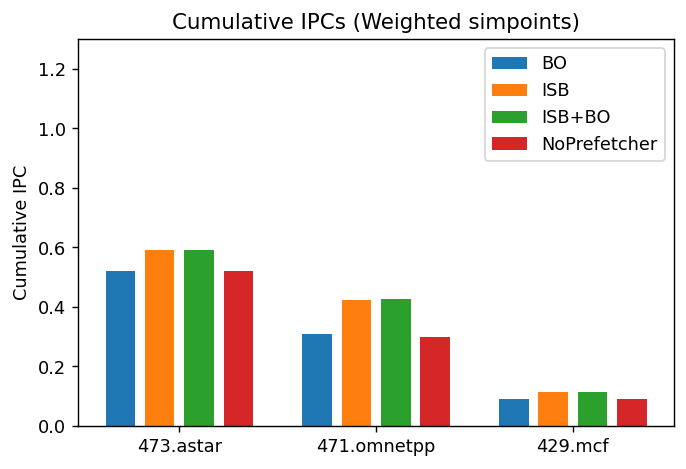

In [127]:
plot_ipcs(wgm_ipcs, subtitle='Weighted simpoints')

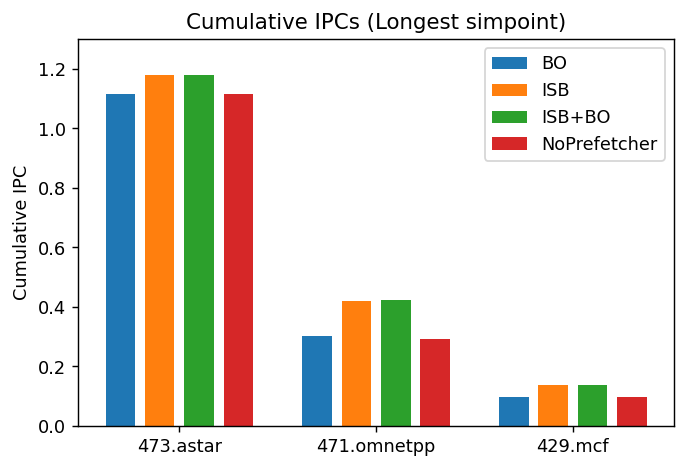

In [128]:
plot_ipcs(ls_ipcs, subtitle='Longest simpoint')

In [64]:
df_ipcs(wgm_ipcs)

,473.astar,471.omnetpp,429.mcf
BO,0.521664,0.307991,0.088576
NoPrefetcher,0.519859,0.298076,0.088573
ISB,0.592629,0.423815,0.112325
ISB+BO,0.592681,0.426096,0.112348


In [65]:
df_ipcs(ls_ipcs)

,473.astar,471.omnetpp,429.mcf
BO,1.11591,0.301012,0.098140
NoPrefetcher,1.11591,0.290903,0.098132
ISB,1.18093,0.419039,0.138004
ISB+BO,1.18093,0.421382,0.138053


#### IPC speedup (vs. no prefetcher)

In [122]:
def plot_ipc_speedups(ipc_speedups, subtitle=None):
    """Plot (weighted geometric) mean IPCs for a
    list of prefetchers.
    """
    traces = list(ipc_speedups.keys())
    
    fig, ax = plt.subplots(dpi=128)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    for i, tr in enumerate(traces):
        ax.bar(i, ipc_speedups[tr]['BO'] * 100., color='C0', width = 0.15, label='BO' if i == 0 else '')
        ax.bar(i + 0.2, ipc_speedups[tr]['ISB'] * 100., color='C1', width=0.15, label='ISB' if i == 0 else '')
        ax.bar(i + 0.4, ipc_speedups[tr]['ISB+BO'] * 100., color='C2', width=0.15, label='ISB+BO' if i == 0 else '')
            
    ax.legend()
    ax.set_xticks(np.arange(0, len(traces)) + 0.2)
    ax.set_xticklabels(traces)
    title = 'IPC speedup'
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(title)
    ax.set_ylabel('IPC speedup (%)')
    ax.set_ylim(ymax=50)

def df_ipc_speedups(ipc_speedups):
    ipc_speedups_ = {}
    for k in ipc_speedups.keys():
        ipc_speedups_[k] = {k_ : round(v * 100., 2) for k_, v in ipc_speedups[k].items()}
        ipc_speedups_[k].pop('NoPrefetcher', None)
    return pd.DataFrame.from_dict(ipc_speedups_)

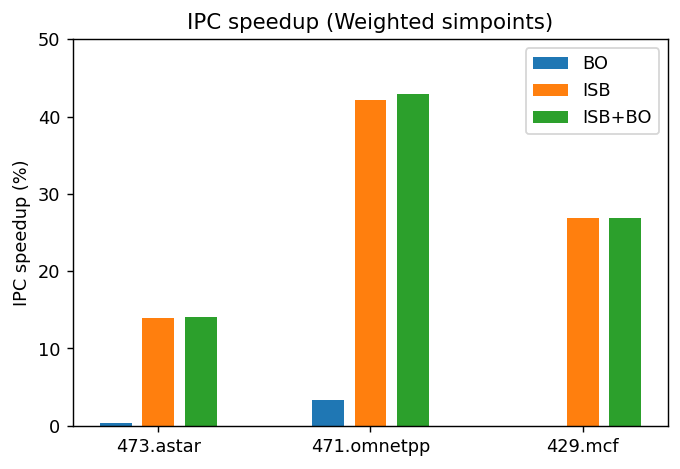

In [123]:
plot_ipc_speedups(wgm_ipc_speedups, subtitle='Weighted simpoints')

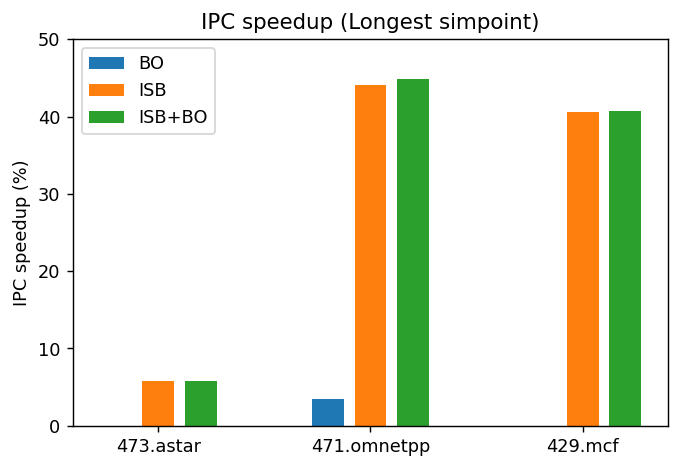

In [124]:
plot_ipc_speedups(ls_ipc_speedups, subtitle='Longest simpoint')

In [70]:
df_ipc_speedups(wgm_ipc_speedups)

,473.astar,471.omnetpp,429.mcf
BO,0.35,3.33,0.00
ISB,14.00,42.18,26.82
ISB+BO,14.01,42.95,26.84


In [71]:
df_ipc_speedups(ls_ipc_speedups)

,473.astar,471.omnetpp,429.mcf
BO,0.00,3.48,0.01
ISB,5.83,44.05,40.63
ISB+BO,5.83,44.85,40.68


---
# Accuracy measurements
Accuracy = useful / (useful + useless) prefetches
- WGM: Take the weighted geometric mean of accuracies for the given trace, using the simpoint weights.
    - WGM accuracy
    - **TODO**: Figure out WGM for prefetchers like BO, that sometimes have zero accuracy. Should we even use WGM?
- Largest simpoint: Only consider accuracy of the largest (highest-weighted) simpoint.
    - LS accuracy
- **TODO**: Include Paper values
- **TODO**: Increase code-reuse from IPC

In [87]:
def get_simpoint_accuracies(results):
    """Parse the results dictionary to get an array
    of simpoint accuracies for each prefetcher. For prefetcher 
    p, simpoint_accs[p][i] is the accuracy of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_accs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_accs[pf][spidx] = sp[pf].accuracy
    return simpoint_accs

def get_wgm_accuracies(results, simpoint_weights):
    """Calculate the weighted geometric mean accuracy 
    of each prefetcher over the simpoints.
    """
    simpoint_accs = get_simpoint_accuracies(results)
    wgm_accs = {}
    for pf in simpoint_accs:
        wgm_accs[pf] = stats.mstats.gmean(simpoint_accs[pf], weights=simpoint_weights)
    return wgm_accs

def get_ls_accuracies(results, simpoint_weights):
    """Calculate the largest simpoint accuracy
    of each prefetcher.
    """
    simpoint_accs = get_simpoint_accuracies(results)
    longest = np.argmax(simpoint_weights)
    ls_accs = {}
    for pf in simpoint_accs:
        ls_accs[pf] = simpoint_accs[pf][longest]
    return ls_accs

In [91]:
wgm_accs = {}
ls_accs = {}

for tr in traces:
    #print(tr, get_simpoint_accuracies(results[tr]))
    #wgm_accs[tr] = get_wgm_accuracies(results[tr], simpoint_weights[tr])
    #print(wgm_accs)
    ls_accs[tr] = get_ls_accuracies(results[tr], simpoint_weights[tr])

In [110]:
def plot_accuracies(accs, subtitle=None):
    """Plot (weighted geometric) mean IPCs for a
    list of prefetchers.
    """
    traces = list(accs.keys())
    
    fig, ax = plt.subplots(dpi=128)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    #print(results)
    #print(traces)
    #print(results[traces[0]]['BO'])
    
    for i, tr in enumerate(traces):
        ax.bar(i, accs[tr]['BO'] * 100., color='C0', width = 0.15, label='BO' if i == 0 else '')
        ax.bar(i + 0.2, accs[tr]['ISB'] * 100., color='C1', width=0.15, label='ISB' if i == 0 else '')
        ax.bar(i + 0.4, accs[tr]['ISB+BO'] * 100., color='C2', width=0.15, label='ISB+BO' if i == 0 else '')
            
    ax.legend()
    ax.set_xticks(np.arange(0, len(traces)) + 0.2)
    ax.set_xticklabels(traces)
    title = 'Accuracy'
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(title)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(ymin=0, ymax=100)
    
def df_accuracies(accs):
    accs_ = {}
    for k in accs.keys():
        accs_[k] = {k_ : round(v * 100., 2) for k_, v in accs[k].items()}
        accs_[k].pop('NoPrefetcher', None)
    return pd.DataFrame.from_dict(accs_)

In [106]:
#plot_accuracies(wgm_accs, subtitle='Weighted simpoints')

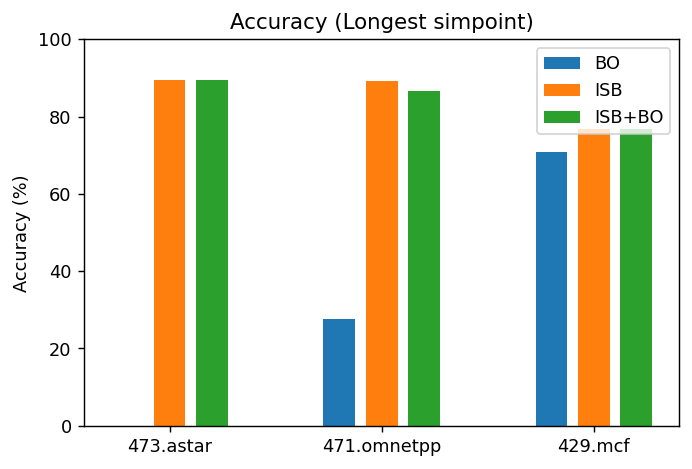

In [111]:
plot_accuracies(ls_accs, subtitle='Longest simpoint')

In [ ]:
#df_accuracies(wgm_accs)

In [104]:
df_accuracies(ls_accs)

,473.astar,471.omnetpp,429.mcf
BO,0.00,27.53,70.78
ISB,89.42,89.17,76.82
ISB+BO,89.42,86.70,76.84


---
# Coverage measurements
Coverage = Percent increase of:
- \# of LLC load + RFO hits on a prefetcher
- vs. # of LLC load + RFO hits on baseline (NoPrefetcher)
- WGM: Take the weighted geometric mean of coverages for the given trace, using the simpoint weights.
    - WGM coverage
    - **TODO**
- Largest simpoint: Only consider coveraeg of the largest (highest-weighted) simpoint.
    - LS coverage
    - **TODO**
- **TODO**: Include Paper values
- **TODO**: Increase code-reuse from IPC